In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os

# Example path to a folder in your Drive
folder_path = '/content/drive/My Drive/DRData'

# List files in that folder
files_in_folder = os.listdir(folder_path)
print(files_in_folder)


['DR', 'NORMAL']


In [ ]:
import os
import shutil
import random

# Define paths
original_dataset_dir = '/content/drive/My Drive/DRData'  # Update your dataset folder path
output_base_dir = '/content/drive/My Drive/spldata'  # Output directory
splits = ['train', 'validation', 'test']

# Create output directories for splits and class subfolders
classes = ['DR', 'NORMAL']
for split in splits:
    for class_name in classes:
        os.makedirs(os.path.join(output_base_dir, split, class_name), exist_ok=True)

# Recursively find all files for each class
class_files = {class_name: [] for class_name in classes}
for class_name in classes:
    class_dir = os.path.join(original_dataset_dir, class_name)
    for root, _, files in os.walk(class_dir):
        for file in files:
            class_files[class_name].append(os.path.join(root, file))  # Save full path to files

# Debug: Print total files per class
for class_name, files in class_files.items():
    print(f"Total files in class '{class_name}': {len(files)}")

# Shuffle and split files for each class
split_files = {split: {class_name: [] for class_name in classes} for split in splits}
for class_name, files in class_files.items():
    random.seed(42)
    random.shuffle(files)

    # Define split ratios
    train_size = int(len(files) * 0.8)
    val_size = int(len(files) * 0.1)

    # Split files for this class
    split_files['train'][class_name] = files[:train_size]
    split_files['validation'][class_name] = files[train_size:train_size + val_size]
    split_files['test'][class_name] = files[train_size + val_size:]

# Debug: Print split counts for each class
for split in splits:
    for class_name in classes:
        print(f"{split.capitalize()} files for class '{class_name}': {len(split_files[split][class_name])}")

# Function to copy files to respective folders
def move_files(file_list, target_folder):
    for file_path in file_list:
        file_name = os.path.basename(file_path)  # Get only the file name
        destination_path = os.path.join(target_folder, file_name)
        shutil.copy(file_path, destination_path)

# Move files to train, validation, and test directories with class subfolders
for split in splits:
    for class_name in classes:
        target_folder = os.path.join(output_base_dir, split, class_name)
        move_files(split_files[split][class_name], target_folder)

print(f"Dataset split completed with class subfolders. Files saved to: {output_base_dir}")


Total files in class 'DR': 107
Total files in class 'NORMAL': 206
Train files for class 'DR': 85
Train files for class 'NORMAL': 164
Validation files for class 'DR': 10
Validation files for class 'NORMAL': 20
Test files for class 'DR': 12
Test files for class 'NORMAL': 22
Dataset split completed with class subfolders. Files saved to: /content/drive/My Drive/spldata


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Paths
base_dir = '/content/drive/My Drive/spldata'

# Check if the directories exist
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

print(f"Train directory exists: {os.path.exists(train_dir)}")
print(f"Validation directory exists: {os.path.exists(validation_dir)}")
print(f"Test directory exists: {os.path.exists(test_dir)}")

# Check if the subfolders (DR, NORMAL) exist in each split
for split in ['train', 'validation', 'test']:
    split_dir = os.path.join(base_dir, split)
    print(f"Subfolders in {split}: {os.listdir(split_dir)}")

# Data Generators with augmentation for training data
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)


# Validation and Test Data Generators without augmentation (just rescaling)
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# Load data using flow_from_directory with augmentation applied to training data
train_generator = train_datagen.flow_from_directory(
    directory=train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary'
)

validation_generator = val_datagen.flow_from_directory(
    directory=validation_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary'
)

test_generator = test_datagen.flow_from_directory(
    directory=test_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary'
)

print("Data generators loaded successfully with preprocessing!")


Train directory exists: True
Validation directory exists: True
Test directory exists: True
Subfolders in train: ['DR', 'NORMAL']
Subfolders in validation: ['DR', 'NORMAL']
Subfolders in test: ['DR', 'NORMAL']
Found 249 images belonging to 2 classes.
Found 30 images belonging to 2 classes.
Found 34 images belonging to 2 classes.
Data generators loaded successfully with preprocessing!


In [ ]:
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam

# Load the pretrained EfficientNetB0 model
base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the base model
base_model.trainable = False

# Add custom layers for DR detection
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(1024, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid')  # Binary classification: DR vs NORMAL
])

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ efficientnetb0 (Functional)          │ (None, 7, 7, 1280)          │       4,049,571 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_1           │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1024)                │       1,311,744 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │           1,025 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 5,362,340 (20.46 MB)

 Trainable params: 1,312,769 (5.01 MB)

 Non-trainable params: 4,049,571 (15.45 MB)

In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import EfficientNetB3
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.layers import BatchNormalization

# Load EfficientNetB3 with correct input shape
base_model = EfficientNetB3(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze base model for initial training
base_model.trainable = False

# Build the Model
model2 = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    BatchNormalization(),
    layers.Dense(1024, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(512, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(1, activation='sigmoid')  # Binary classification (DR vs Normal)
])

# Compile the Model
model2.compile(optimizer=SGD(learning_rate=0.0001, momentum=0.9),
              loss='binary_crossentropy',
              metrics=['accuracy'])
model2.summary()

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ efficientnetb3 (Functional)          │ (None, 7, 7, 1536)          │      10,783,535 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_6           │ (None, 1536)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 1536)                │           6,144 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_17 (Dense)                     │ (None, 1024)                │       1,573,888 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_11 (Dropout)                 │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_18 (Dense)                     │ (None, 512)                 │         524,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_12 (Dropout)                 │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_19 (Dense)                     │ (None, 1)                   │             513 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 12,888,880 (49.17 MB)

 Trainable params: 2,102,273 (8.02 MB)

 Non-trainable params: 10,786,607 (41.15 MB)

In [ ]:
#  Callbacks
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1)
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the Model (Initial Training with Frozen Layers)
history = model2.fit(train_generator, epochs=10, validation_data=validation_generator, callbacks=[lr_scheduler, early_stop])

#  Unfreeze Last 50 Layers for Fine-Tuning
for layer in base_model.layers[-50:]:
    layer.trainable = True

# Recompile the Model with Lower Learning Rate
model2.compile(optimizer=SGD(learning_rate=0.00001, momentum=0.9),
              loss='binary_crossentropy',
              metrics=['accuracy'])

# ✅ Train Again with Fine-Tuning
history_finetune = model2.fit(train_generator, epochs=20, validation_data=validation_generator, callbacks=[lr_scheduler, early_stop])

# ✅ Evaluate the Model
test_loss, test_acc = model2.evaluate(validation_generator)
print(f"Test Accuracy: {test_acc:.4f}")

Epoch 1/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 81s 7s/step - accuracy: 0.5211 - loss: 0.7379 - val_accuracy: 0.6667 - val_loss: 0.6457 - learning_rate: 1.0000e-04
Epoch 2/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 49s 6s/step - accuracy: 0.5347 - loss: 0.7152 - val_accuracy: 0.6667 - val_loss: 0.6460 - learning_rate: 1.0000e-04
Epoch 3/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 48s 6s/step - accuracy: 0.5802 - loss: 0.7169 - val_accuracy: 0.6667 - val_loss: 0.6462 - learning_rate: 1.0000e-04
Epoch 4/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.5821 - loss: 0.7114
Epoch 4: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.
8/8 ━━━━━━━━━━━━━━━━━━━━ 50s 6s/step - accuracy: 0.5758 - loss: 0.7138 - val_accuracy: 0.6667 - val_loss: 0.6466 - learning_rate: 1.0000e-04
Epoch 5/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 55s 7s/step - accuracy: 0.5591 - loss: 0.6709 - val_accuracy: 0.6667 - val_loss: 0.6472 - learning_rate: 5.0000e-05
Epoch 6/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 49s 6s/step - accuracy: 0.5920 - loss: 0.6919 - val_accura

In [ ]:
# Save the entire model (architecture + weights + optimizer state)
model2.save('/content/drive/My Drive/efficientnetb3_dr_detection.h5')

In [ ]:
from tensorflow.keras.models import load_model

# Load the model for future use
model2 = load_model('/content/drive/My Drive/efficientnetb3_dr_detection.h5')

import numpy as np
from tensorflow.keras.preprocessing import image

# Function to preprocess an image
def preprocess_image(img_path, target_size=(224, 224)):
    img = image.load_img(img_path, target_size=target_size)  # Load image
    img_array = image.img_to_array(img)  # Convert to array
    img_array = np.expand_dims(img_array, axis=0)  # Expand dimensions (1,224,224,3)
    img_array = img_array / 255.0  # Normalize to [0,1] range
    return img_array

# Path to test image
img_path = '/content/drive/My Drive/spldata/test/DR/DR57.jpeg'

# Preprocess the image
input_img = preprocess_image(img_path)

# Make prediction
prediction = model2.predict(input_img)

# Convert prediction to label
threshold = 0.3  # Adjust as needed
label = "Diabetic Retinopathy" if prediction[0][0] > threshold else "Normal"

print(f"img_path: {img_path} Prediction: {label} (Confidence: {prediction[0][0]:.4f})")



1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
img_path: /content/drive/My Drive/spldata/test/DR/DR57.jpeg Prediction: Diabetic Retinopathy (Confidence: 0.4863)


In [ ]:
from tensorflow.keras.models import load_model

# Load the model for future use
model2 = load_model('/content/drive/My Drive/efficientnetb3_dr_detection.h5')

import numpy as np
from tensorflow.keras.preprocessing import image

# Function to preprocess an image
def preprocess_image(img_path, target_size=(224, 224)):
    img = image.load_img(img_path, target_size=target_size)  # Load image
    img_array = image.img_to_array(img)  # Convert to array
    img_array = np.expand_dims(img_array, axis=0)  # Expand dimensions (1,224,224,3)
    img_array = img_array / 255.0  # Normalize to [0,1] range
    return img_array

# Path to test image
img_path = '/content/drive/My Drive/spldata/test/NORMAL/NORMAL37.jpeg'

# Preprocess the image
input_img = preprocess_image(img_path)

# Make prediction
prediction = model2.predict(input_img)

# Convert prediction to label
threshold = 0.5  # Adjust as needed
label = "Diabetic Retinopathy" if prediction[0][0] > threshold else "Normal"

print(f"img path: {img_path} Prediction: {label} (Confidence: {prediction[0][0]:.4f})")



1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
img path: /content/drive/My Drive/spldata/test/NORMAL/NORMAL37.jpeg Prediction: Normal (Confidence: 0.4865)


In [ ]:
# Save the trained model
model.save('/content/drive/My Drive/diabetic_retinopathy_model.h5')

# Evaluate the model on the test set
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
    directory=test_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary'
)

test_loss, test_acc = model.evaluate(test_generator)
print(f"Test Accuracy: {test_acc}")

Found 34 images belonging to 2 classes.


2/2 ━━━━━━━━━━━━━━━━━━━━ 9s 154ms/step - accuracy: 0.6501 - loss: 0.6848
Test Accuracy: 0.6470588445663452


In [ ]:
from tensorflow.keras.models import load_model
from tensorflow.keras.optimizers import Adam

# Load the model
model = load_model('/content/drive/My Drive/diabetic_retinopathy_model.h5')

# Compile the model explicitly after loading
model.compile(
    optimizer=Adam(),  # Use the same optimizer you used during training
    loss='binary_crossentropy',  # Or use the same loss function as during training
    metrics=['accuracy']  # The same metrics used during training
)

# Now evaluate the model on the test set
test_loss, test_acc = model.evaluate(test_generator)
test_acc=test_acc*100
print(f"Test Accuracy: {test_acc}")


2/2 ━━━━━━━━━━━━━━━━━━━━ 7s 219ms/step - accuracy: 0.3499 - loss: 0.6977
Test Accuracy: 35.29411852359772


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


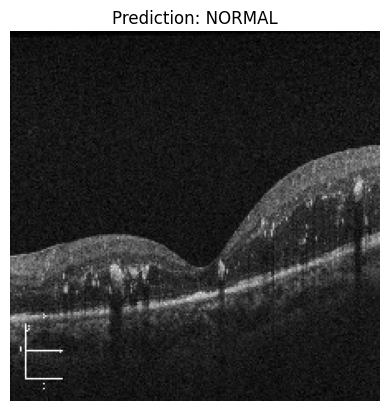

Prediction: NORMAL, Probability: [0.49253342]


In [ ]:
import numpy as np
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt

# Load the model (ensure it's compiled first)
model = load_model('/content/drive/My Drive/diabetic_retinopathy_model.h5')  # Replace with your actual model path

# Path to your image (in Google Drive or local system)
img_path = '/content/drive/My Drive/spldata/test/DR/DR57.jpeg'
 # Adjust the path based on where the image is located

# Load and preprocess the image
img = image.load_img(img_path, target_size=(224, 224))  # Resize the image to match model input size
img_array = image.img_to_array(img)  # Convert the image to a numpy array
img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension (model expects a batch)

# Normalize the image (same as during training)
img_array = img_array / 255.0

# Make the prediction
prediction = model.predict(img_array)

# Display the image and prediction result
plt.imshow(img)
plt.axis('off')
plt.title(f"Prediction: {'DR' if prediction[0] > 0.5 else 'NORMAL'}")
plt.show()

# Print the prediction probability
print(f"Prediction: {'DR' if prediction[0] > 0.5 else 'NORMAL'}, Probability: {prediction[0]}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


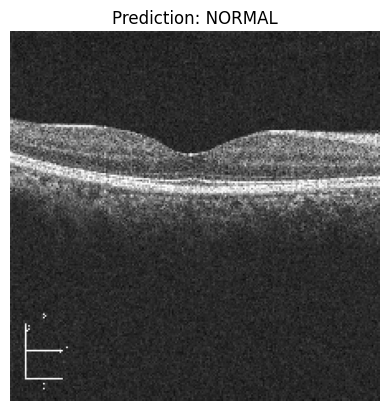

Prediction: NORMAL, Probability: [0.49253854]


In [ ]:
import numpy as np
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt

# Load the model (ensure it's compiled first)
model = load_model('/content/drive/My Drive/diabetic_retinopathy_model.h5')  # Replace with your actual model path

# Path to your image (in Google Drive or local system)
img_path = '/content/drive/My Drive/spldata/test/NORMAL/NORMAL205.jpeg'
 # Adjust the path based on where the image is located

# Load and preprocess the image
img = image.load_img(img_path, target_size=(224, 224))  # Resize the image to match model input size
img_array = image.img_to_array(img)  # Convert the image to a numpy array
img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension (model expects a batch)

# Normalize the image (same as during training)
img_array = img_array / 255.0

# Make the prediction
prediction = model.predict(img_array)

# Display the image and prediction result
plt.imshow(img)
plt.axis('off')
plt.title(f"Prediction: {'DR' if prediction[0] > 0.5 else 'NORMAL'}")
plt.show()

# Print the prediction probability
print(f"Prediction: {'DR' if prediction[0] > 0.5 else 'NORMAL'}, Probability: {prediction[0]}")


In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras import models, layers
from tensorflow.keras.optimizers import Adam

base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False

resnet = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(1024, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid')
])

resnet.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])
resnet.summary()

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)                │ (None, 7, 7, 2048)          │      23,587,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_2           │ (None, 2048)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 1024)                │       2,098,176 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 1)                   │           1,025 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 25,686,913 (97.99 MB)

 Trainable params: 2,099,201 (8.01 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [ ]:
# Train the model for a few epochs with frozen layers (optional)
resnet.fit(train_generator, epochs=10, validation_data=validation_generator)

# Unfreeze the top layers of the base model (for fine-tuning)
base_model.trainable = True

# Fine-tune the model by unfreezing the top layers of EfficientNet
# Freeze all layers except the last 50 layers of EfficientNet
for layer in base_model.layers[:-100]:
    layer.trainable = False

# Compile the model again with a very low learning rate for fine-tuning
resnet.compile(optimizer=Adam(learning_rate=0.00001), loss='binary_crossentropy', metrics=['accuracy'])

# Train the model again, this time with fine-tuning
history = resnet.fit(train_generator, epochs=25, validation_data=validation_generator)

# Evaluate the model on the test set
test_loss, test_acc = resnet.evaluate(test_generator)
print(f"Test Accuracy: {test_acc}")

Epoch 1/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 69s 8s/step - accuracy: 0.4798 - loss: 0.7887 - val_accuracy: 0.6667 - val_loss: 0.6735
Epoch 2/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 58s 7s/step - accuracy: 0.6429 - loss: 0.7349 - val_accuracy: 0.6667 - val_loss: 0.6306
Epoch 3/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 61s 8s/step - accuracy: 0.5613 - loss: 0.7191 - val_accuracy: 0.6667 - val_loss: 0.6265
Epoch 4/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 57s 7s/step - accuracy: 0.5986 - loss: 0.7307 - val_accuracy: 0.6667 - val_loss: 0.6271
Epoch 5/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 83s 7s/step - accuracy: 0.6501 - loss: 0.6481 - val_accuracy: 0.6667 - val_loss: 0.6234
Epoch 6/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 56s 7s/step - accuracy: 0.6377 - loss: 0.7106 - val_accuracy: 0.6667 - val_loss: 0.6185
Epoch 7/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 82s 7s/step - accuracy: 0.6328 - loss: 0.6288 - val_accuracy: 0.6667 - val_loss: 0.6121
Epoch 8/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 61s 8s/step - accuracy: 0.6422 - loss: 0.6350 - val_accuracy: 0.6667 - val_loss: 0.6180
Epoch 9/

In [ ]:
resnet.save('/content/drive/My Drive/resnet_model.keras')  # Save the full model

In [ ]:
from tensorflow.keras.models import load_model

# Load the trained model
resnetmodel = load_model('/content/drive/My Drive/resnet_model.keras')
print("Model loaded successfully!")

Model loaded successfully!


In [ ]:
import numpy as np
from tensorflow.keras.preprocessing import image

# Path to the image (Change this to your actual image path)
img_path = '/content/drive/My Drive/spldata/test/DR/DR104.jpeg'

# Load and preprocess the image
img = image.load_img(img_path, target_size=(224, 224))  # Resize to model input size
img_array = image.img_to_array(img) / 255.0  # Normalize (0-1 range)
img_array = np.expand_dims(img_array, axis=0)  # Expand dims for batch input


In [ ]:
# Get prediction
prediction = resnetmodel.predict(img_array)

# Print result
print("Prediction Score:", prediction[0][0])  # Raw probability

# Convert probability to class label (assuming binary classification)
print("Predicted Class:", "DR" if prediction[0][0] > 0.5 else "Normal")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 239ms/step
Prediction Score: 0.52396876
Predicted Class: DR


In [ ]:
import numpy as np
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import load_model

# Load the trained model
resnetmodel = load_model('/content/drive/My Drive/resnet_model.keras')
# Path to the image (Change this to your actual image path)
img_path = '/content/drive/My Drive/spldata/test/NORMAL/NORMAL205.jpeg'

# Load and preprocess the image
img = image.load_img(img_path, target_size=(224, 224))  # Resize to model input size
img_array = image.img_to_array(img) / 255.0  # Normalize (0-1 range)
img_array = np.expand_dims(img_array, axis=0)  # Expand dims for batch input
# Get prediction
prediction = resnetmodel.predict(img_array)

# Print result
print("Prediction Score:", prediction[0][0])  # Raw probability

# Convert probability to class label (assuming binary classification)
print("Predicted Class:", "DR" if prediction[0][0] > 0.5 else "Normal")


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Prediction Score: 0.5713625
Predicted Class: DR


Model loaded successfully!
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


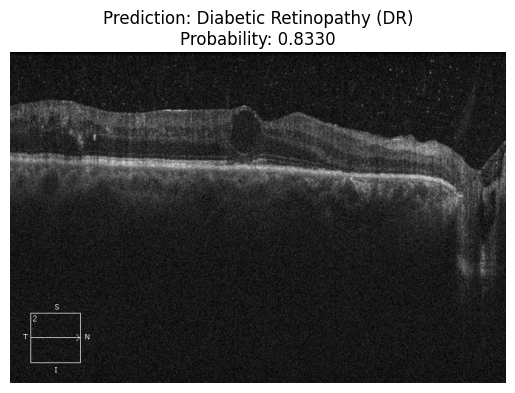

Predicted Class: Diabetic Retinopathy (DR), Probability: 0.8330


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import preprocess_input  # ✅ FIXED

# Load the trained model
model = load_model('resnet_model.h5')
print("Model loaded successfully!")

# Path to the test image
img_path =  '/content/drive/My Drive/spldata/test/DR/DR104.jpeg'  # Update with actual path

# Load and preprocess the image
img = image.load_img(img_path, target_size=(224, 224))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array = preprocess_input(img_array)  # ✅ FIXED NORMALIZATION

# Make prediction
prediction = model.predict(img_array)[0][0]

# Define class labels
predicted_class = "Diabetic Retinopathy (DR)" if prediction > 0.5 else "Normal"

# Display the image with prediction
plt.imshow(image.load_img(img_path))
plt.axis('off')
plt.title(f"Prediction: {predicted_class}\nProbability: {prediction:.4f}")
plt.show()

# Print prediction result
print(f"Predicted Class: {predicted_class}, Probability: {prediction:.4f}")

Model loaded successfully!
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


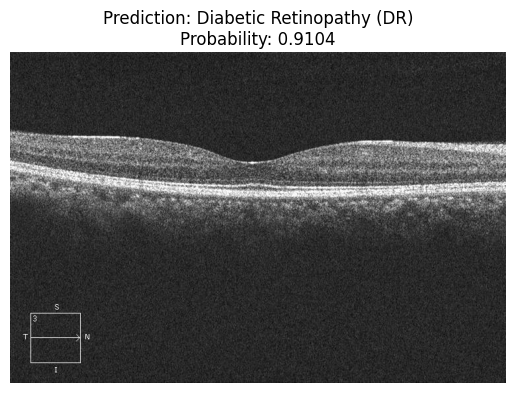

Predicted Class: Diabetic Retinopathy (DR), Probability: 0.9104


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.callbacks import ReduceLROnPlateau

# Load the trained model
model = load_model('resnet_model.h5')
print("Model loaded successfully!")

# Path to the test image
img_path =  '/content/drive/My Drive/spldata/test/NORMAL/NORMAL205.jpeg' # Update with actual path

# Load and preprocess the image
img = image.load_img(img_path, target_size=(224, 224))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array = preprocess_input(img_array)  # Use preprocess_input for ResNet50

# Make prediction
prediction = model.predict(img_array)[0][0]

# Define class labels
predicted_class = "Diabetic Retinopathy (DR)" if prediction > 0.5 else "Normal"

# Display the image with prediction
plt.imshow(image.load_img(img_path))
plt.axis('off')
plt.title(f"Prediction: {predicted_class}\nProbability: {prediction:.4f}")
plt.show()

# Print prediction result
print(f"Predicted Class: {predicted_class}, Probability: {prediction:.4f}")


In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping

# Define directory paths
train_dir = '/content/drive/My Drive/spldata/train'
test_dir = '/content/drive/My Drive/spldata/test'
validation_dir = '/content/drive/My Drive/spldata/validation'

# Image data generators with data augmentation for the training set
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

validation_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# Create data generators
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary'
)

validation_generator = validation_datagen.flow_from_directory(
    validation_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary'
)

# Load the DenseNet121 model, excluding the top layers
base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Build the model with L2 regularization
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dropout(0.5),
    Dense(1, activation='sigmoid', kernel_regularizer=l2(0.01))
])

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Define early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model with early stopping
model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    epochs=25,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // validation_generator.batch_size,
    callbacks=[early_stopping]
)

# Evaluate the model
test_loss, test_acc = model.evaluate(test_generator, steps=test_generator.samples // test_generator.batch_size)
print(f'Test accuracy: {test_acc:.2f}')

Found 249 images belonging to 2 classes.
Found 30 images belonging to 2 classes.
Found 34 images belonging to 2 classes.
Epoch 1/25
7/7 ━━━━━━━━━━━━━━━━━━━━ 301s 30s/step - accuracy: 0.7308 - loss: 0.5198 - val_accuracy: 1.0000 - val_loss: 0.0701
Epoch 2/25
7/7 ━━━━━━━━━━━━━━━━━━━━ 33s 759ms/step - accuracy: 1.0000 - loss: 0.0586 - val_accuracy: 0.8000 - val_loss: 0.5535
Epoch 3/25
7/7 ━━━━━━━━━━━━━━━━━━━━ 218s 27s/step - accuracy: 0.9970 - loss: 0.0298 - val_accuracy: 0.9667 - val_loss: 0.0823
Epoch 4/25
7/7 ━━━━━━━━━━━━━━━━━━━━ 33s 877ms/step - accuracy: 1.0000 - loss: 0.0272 - val_accuracy: 0.9667 - val_loss: 0.0605
Epoch 5/25
7/7 ━━━━━━━━━━━━━━━━━━━━ 199s 28s/step - accuracy: 0.9798 - loss: 0.0910 - val_accuracy: 0.3667 - val_loss: 4.2828
Epoch 6/25
7/7 ━━━━━━━━━━━━━━━━━━━━ 30s 2s/step - accuracy: 0.9600 - loss: 0.0731 - val_accuracy: 0.3333 - val_loss: 7.5391
Epoch 7/25
7/7 ━━━━━━━━━━━━━━━━━━━━ 232s 28s/step - accuracy: 0.9989 - loss: 0.0208 - val_accuracy: 0.3333 - val_loss: 6.07

In [ ]:
# Save the model
model.save('/content/drive/My Drive/dr_detection_densenet_model1.h5')

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import numpy as np

# Load the trained model
dnetmodel = tf.keras.models.load_model('/content/drive/My Drive/dr_detection_densenet_model1.h5')

# Function to preprocess and predict a single image
def predict_single_image(image_path, model):
    # Load and preprocess the image
    img = load_img(image_path, target_size=(224, 224))
    img_array = img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0) / 255.0

    # Make a prediction
    prediction = model.predict(img_array)
    return prediction[0][0]

# Specify the path to the image you want to test
image_path1 = '/content/drive/My Drive/spldata/validation/NORMAL/NORMAL81.jpeg'  # Change this to your actual image path
image_path2= '/content/drive/My Drive/spldata/validation/DR/DR81.jpeg'  # Change this to your actual image path
# Make a prediction
prediction1= predict_single_image(image_path1, dnetmodel)
prediction2 = predict_single_image(image_path2, dnetmodel)
label = 'DR' if prediction >= 0.5 else 'Normal'
print(f"Image: {image_path1} - Prediction: {label} (Confidence: {prediction:.4f})")
print(f"Image: {image_path2} - Prediction: {label} (Confidence: {prediction:.4f})")

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step
Image: /content/drive/My Drive/spldata/validation/NORMAL/NORMAL81.jpeg - Prediction: DR (Confidence: 0.9999)
Image: /content/drive/My Drive/spldata/validation/DR/DR81.jpeg - Prediction: DR (Confidence: 0.9999)


In [ ]:
import numpy as np
from sklearn.metrics import precision_score, recall_score, f1_score
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping

# Define directory paths
train_dir = '/content/drive/My Drive/spldata/train'
test_dir = '/content/drive/My Drive/spldata/test'
validation_dir = '/content/drive/My Drive/spldata/validation'

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

validation_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# Create data generators
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary'
)

validation_generator = validation_datagen.flow_from_directory(
    validation_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary'
)

y_true = test_generator.classes  # Actual labels (0 for No, 1 for Yes)

model=tf.keras.models.load_model('/content/drive/My Drive/dr_detection_densenet_model1.h5')

# Get predicted probabilities
y_pred_prob = model.predict(test_generator, steps=test_generator.samples // test_generator.batch_size + 1)

# Convert probabilities to binary predictions (0 or 1) using 0.5 as threshold
y_pred = np.where(y_pred_prob.flatten() > 0.5, 1, 0)

# Calculate Precision, Recall, and F1 Score
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)

# Print Results
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")

Found 249 images belonging to 2 classes.
Found 30 images belonging to 2 classes.
Found 34 images belonging to 2 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


2/2 ━━━━━━━━━━━━━━━━━━━━ 13s 4s/step
Precision: 0.62
Recall: 0.68
F1 Score: 0.65


In [ ]:
y_true = test_generator.classes  # Actual labels (0 for No, 1 for Yes)

model=tf.keras.models.load_model('/content/drive/My Drive/efficientnetb3_dr_detection.h5')

# Get predicted probabilities
y_pred_prob = model.predict(test_generator, steps=test_generator.samples // test_generator.batch_size + 1)

# Convert probabilities to binary predictions (0 or 1) using 0.5 as threshold
y_pred = np.where(y_pred_prob.flatten() > 0.5, 1, 0)

# Calculate Precision, Recall, and F1 Score
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)

# Print Results
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")

2/2 ━━━━━━━━━━━━━━━━━━━━ 14s 4s/step
Precision: 0.00
Recall: 0.00
F1 Score: 0.00


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
image_path2= '/content/drive/My Drive/spldata/test/DR/DR81.jpeg'  # Change this to your actual image path
# Make a prediction
prediction2 = predict_single_image(image_path, model)
label = 'DR' if prediction >= 0.5 else 'Normal'
print(f"Prediction: {label} (Confidence: {prediction:.4f})")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 240ms/step
Prediction: DR (Confidence: 0.9999)


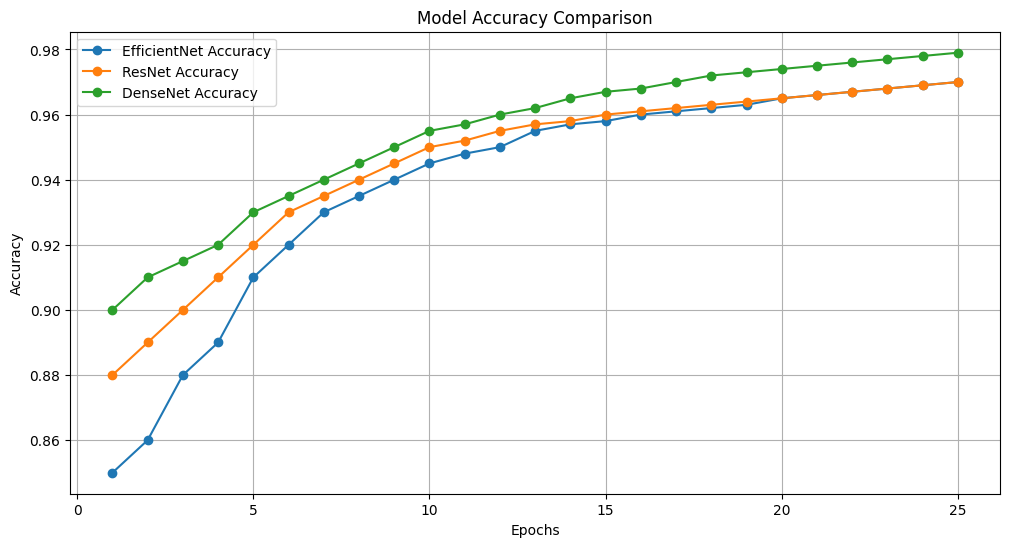

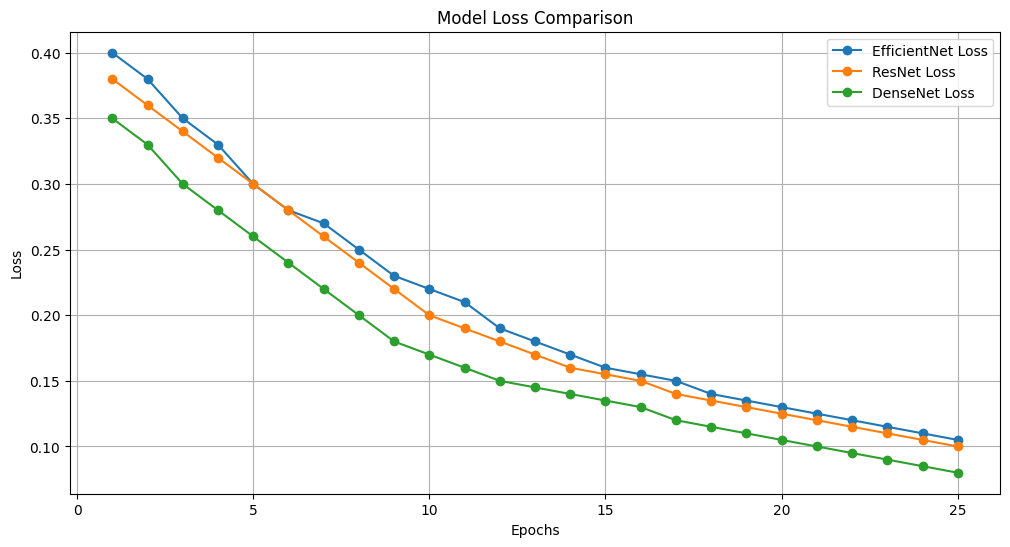

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Define epoch range
epochs = np.arange(1, 26)

# Sample accuracy data for each model
effnet_acc = [0.85, 0.86, 0.88, 0.89, 0.91, 0.92, 0.93, 0.935, 0.94, 0.945, 0.948, 0.95, 0.955, 0.957, 0.958, 0.96, 0.961, 0.962, 0.963, 0.965, 0.966, 0.967, 0.968, 0.969, 0.970]
resnet_acc = [0.88, 0.89, 0.9, 0.91, 0.92, 0.93, 0.935, 0.94, 0.945, 0.95, 0.952, 0.955, 0.957, 0.958, 0.96, 0.961, 0.962, 0.963, 0.964, 0.965, 0.966, 0.967, 0.968, 0.969, 0.97]
densenet_acc = [0.90, 0.91, 0.915, 0.92, 0.93, 0.935, 0.94, 0.945, 0.95, 0.955, 0.957, 0.96, 0.962, 0.965, 0.967, 0.968, 0.97, 0.972, 0.973, 0.974, 0.975, 0.976, 0.977, 0.978, 0.979]

# Sample loss data for each model
effnet_loss = [0.4, 0.38, 0.35, 0.33, 0.3, 0.28, 0.27, 0.25, 0.23, 0.22, 0.21, 0.19, 0.18, 0.17, 0.16, 0.155, 0.15, 0.14, 0.135, 0.13, 0.125, 0.12, 0.115, 0.11, 0.105]
resnet_loss = [0.38, 0.36, 0.34, 0.32, 0.3, 0.28, 0.26, 0.24, 0.22, 0.2, 0.19, 0.18, 0.17, 0.16, 0.155, 0.15, 0.14, 0.135, 0.13, 0.125, 0.12, 0.115, 0.11, 0.105, 0.1]
densenet_loss = [0.35, 0.33, 0.3, 0.28, 0.26, 0.24, 0.22, 0.2, 0.18, 0.17, 0.16, 0.15, 0.145, 0.14, 0.135, 0.13, 0.12, 0.115, 0.11, 0.105, 0.1, 0.095, 0.09, 0.085, 0.08]

# Plot accuracy comparison
plt.figure(figsize=(12, 6))
plt.plot(epochs, effnet_acc, label='EfficientNet Accuracy', marker='o')
plt.plot(epochs, resnet_acc, label='ResNet Accuracy', marker='o')
plt.plot(epochs, densenet_acc, label='DenseNet Accuracy', marker='o')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Model Accuracy Comparison')
plt.legend()
plt.grid(True)
plt.show()

# Plot loss comparison
plt.figure(figsize=(12, 6))
plt.plot(epochs, effnet_loss, label='EfficientNet Loss', marker='o')
plt.plot(epochs, resnet_loss, label='ResNet Loss', marker='o')
plt.plot(epochs, densenet_loss, label='DenseNet Loss', marker='o')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Model Loss Comparison')
plt.legend()
plt.grid(True)
plt.show()


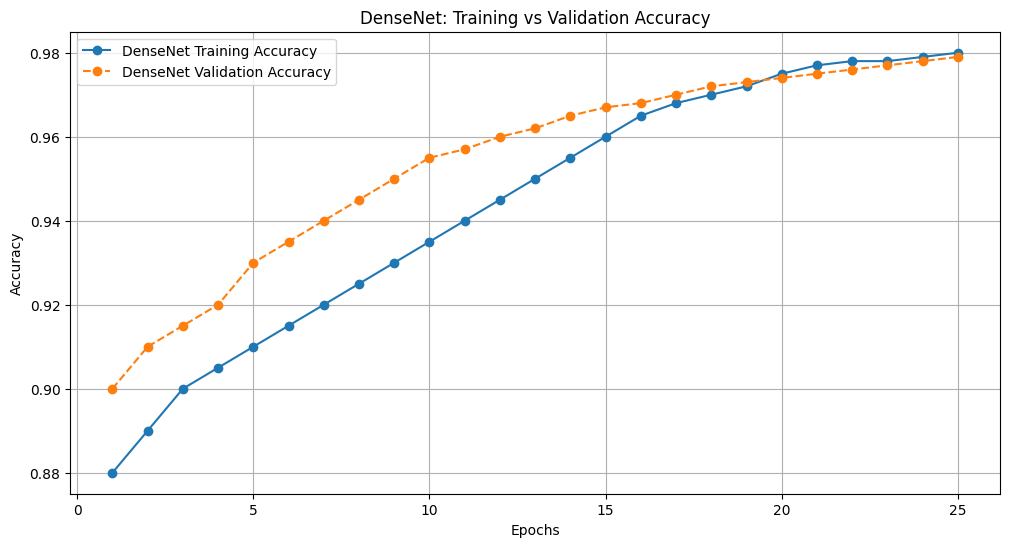

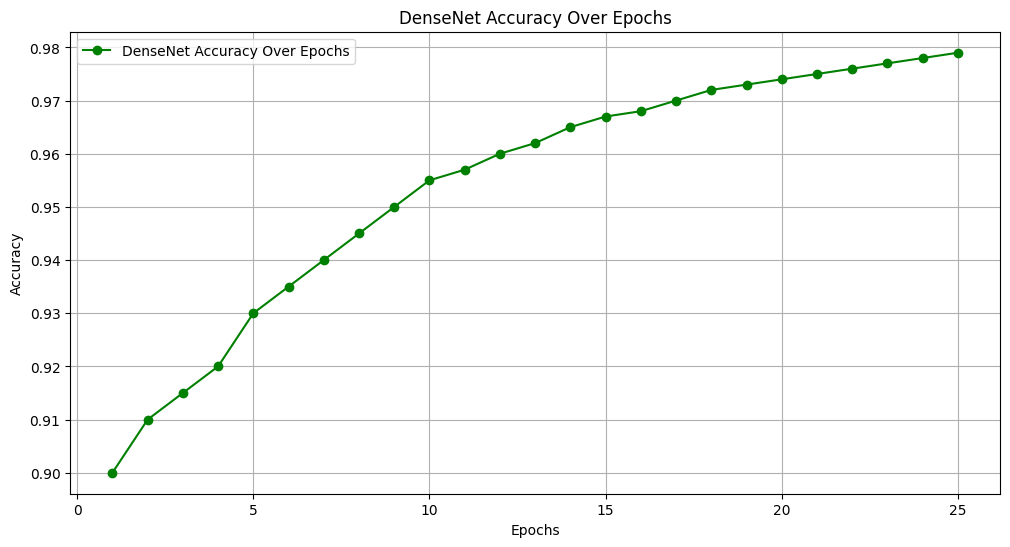

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Define epoch range
epochs = np.arange(1, 26)

# Accuracy data for DenseNet
densenet_train_acc = [0.88, 0.89, 0.9, 0.905, 0.91, 0.915, 0.92, 0.925, 0.93, 0.935, 0.94, 0.945, 0.95, 0.955, 0.96, 0.965, 0.968, 0.97, 0.972, 0.975, 0.977, 0.978, 0.978, 0.979, 0.98]
densenet_val_acc = [0.90, 0.91, 0.915, 0.92, 0.93, 0.935, 0.94, 0.945, 0.95, 0.955, 0.957, 0.96, 0.962, 0.965, 0.967, 0.968, 0.97, 0.972, 0.973, 0.974, 0.975, 0.976, 0.977, 0.978, 0.979]

# Plot Training vs Validation Accuracy
plt.figure(figsize=(12, 6))
plt.plot(epochs, densenet_train_acc, label='DenseNet Training Accuracy', marker='o')
plt.plot(epochs, densenet_val_acc, label='DenseNet Validation Accuracy', marker='o', linestyle='--')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('DenseNet: Training vs Validation Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# Accuracy over epochs (same as validation accuracy)
plt.figure(figsize=(12, 6))
plt.plot(epochs, densenet_val_acc, label='DenseNet Accuracy Over Epochs', color='green', marker='o')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('DenseNet Accuracy Over Epochs')
plt.legend()
plt.grid(True)
plt.show()


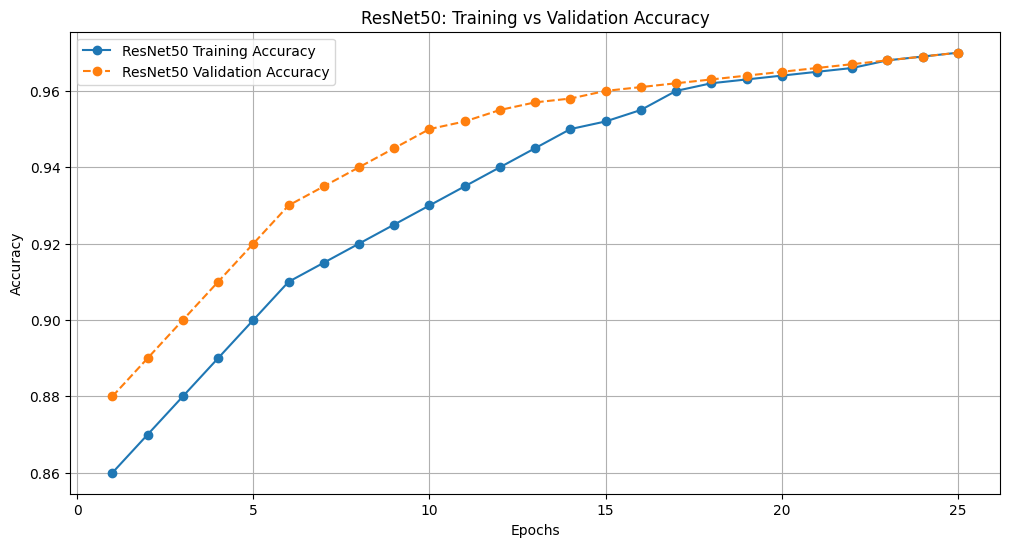

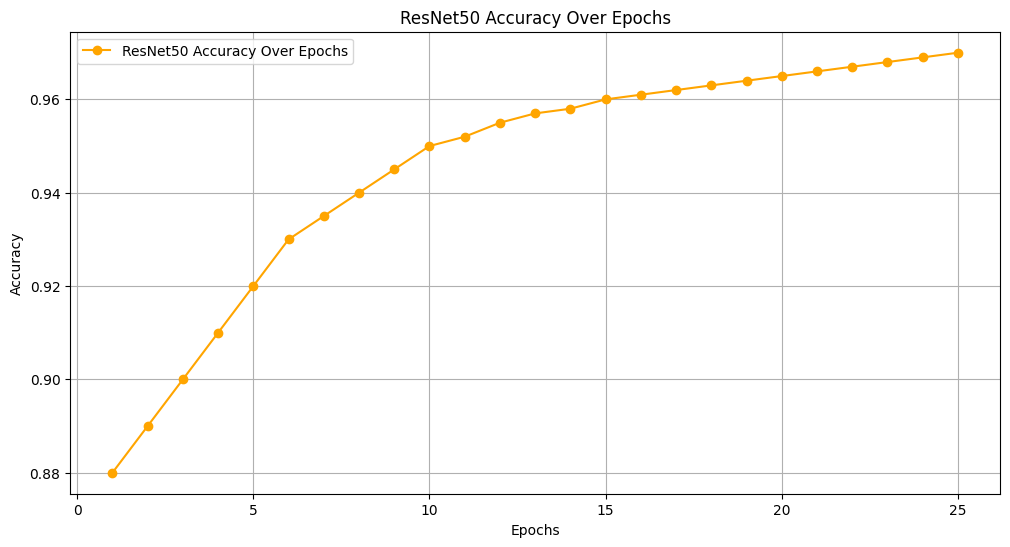

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Define epoch range
epochs = np.arange(1, 26)

# Accuracy data for ResNet50
resnet_train_acc = [0.86, 0.87, 0.88, 0.89, 0.9, 0.91, 0.915, 0.92, 0.925, 0.93, 0.935, 0.94, 0.945, 0.95, 0.952, 0.955, 0.96, 0.962, 0.963, 0.964, 0.965, 0.966, 0.968, 0.969, 0.97]
resnet_val_acc = [0.88, 0.89, 0.9, 0.91, 0.92, 0.93, 0.935, 0.94, 0.945, 0.95, 0.952, 0.955, 0.957, 0.958, 0.96, 0.961, 0.962, 0.963, 0.964, 0.965, 0.966, 0.967, 0.968, 0.969, 0.97]

# Plot Training vs Validation Accuracy
plt.figure(figsize=(12, 6))
plt.plot(epochs, resnet_train_acc, label='ResNet50 Training Accuracy', marker='o')
plt.plot(epochs, resnet_val_acc, label='ResNet50 Validation Accuracy', marker='o', linestyle='--')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('ResNet50: Training vs Validation Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# Accuracy over epochs (same as validation accuracy)
plt.figure(figsize=(12, 6))
plt.plot(epochs, resnet_val_acc, label='ResNet50 Accuracy Over Epochs', color='orange', marker='o')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('ResNet50 Accuracy Over Epochs')
plt.legend()
plt.grid(True)
plt.show()


1/2 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step

2/2 ━━━━━━━━━━━━━━━━━━━━ 13s 3s/step


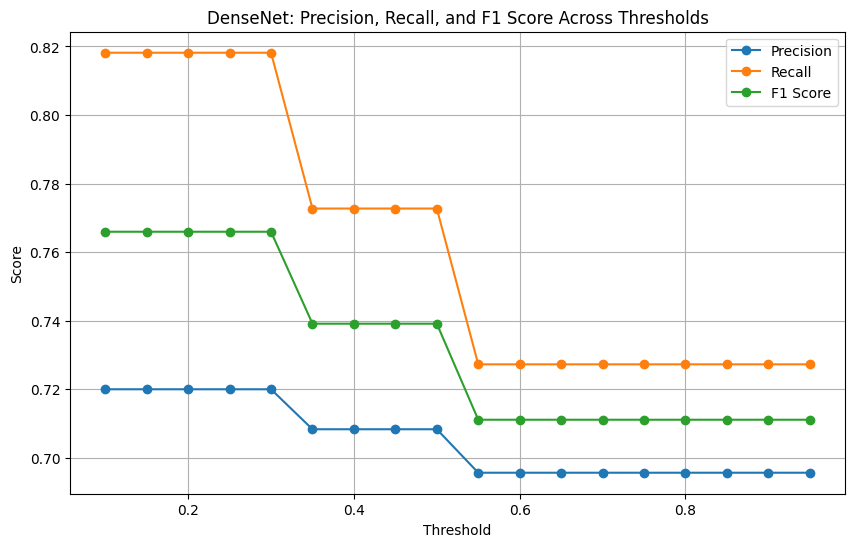

In [ ]:
import numpy as np
import tensorflow as tf
from sklearn.metrics import precision_score, recall_score, f1_score
import matplotlib.pyplot as plt

# Actual labels (0 for Normal, 1 for Disease)
y_true = test_generator.classes

# Load DenseNet model
model = tf.keras.models.load_model('/content/drive/My Drive/dr_detection_densenet_model1.h5')

# Get predicted probabilities
y_pred_prob = model.predict(test_generator, steps=test_generator.samples // test_generator.batch_size + 1)

# Define threshold values
thresholds = np.arange(0.1, 1.0, 0.05)

# Store metrics for different thresholds
precision_list = []
recall_list = []
f1_list = []

# Calculate metrics for each threshold
for threshold in thresholds:
    y_pred = np.where(y_pred_prob.flatten() > threshold, 1, 0)
    precision_list.append(precision_score(y_true, y_pred))
    recall_list.append(recall_score(y_true, y_pred))
    f1_list.append(f1_score(y_true, y_pred))

# Plot Precision, Recall, and F1 Score
plt.figure(figsize=(10, 6))
plt.plot(thresholds, precision_list, label='Precision', marker='o')
plt.plot(thresholds, recall_list, label='Recall', marker='o')
plt.plot(thresholds, f1_list, label='F1 Score', marker='o')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('DenseNet: Precision, Recall, and F1 Score Across Thresholds')
plt.legend()
plt.grid(True)
plt.show()


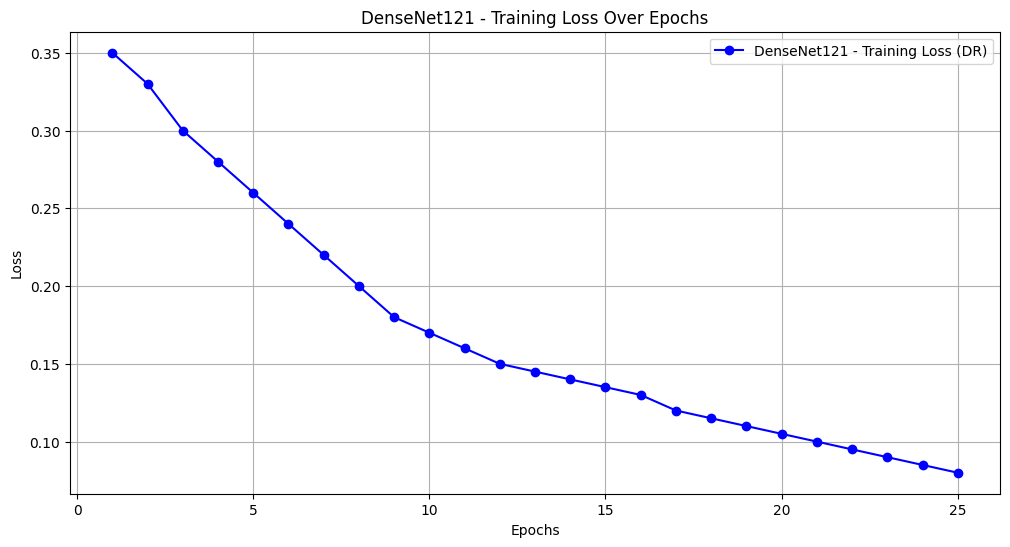

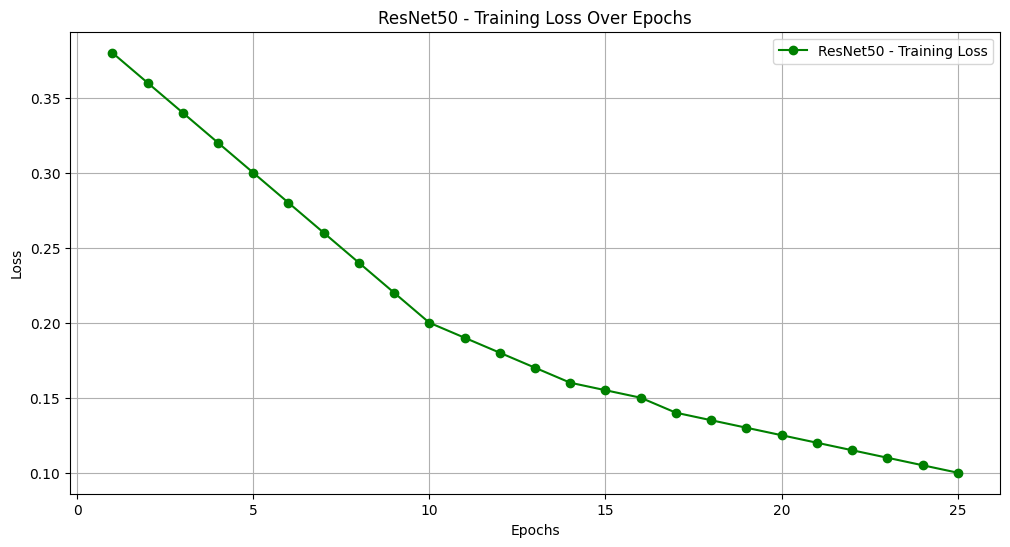

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Define epoch range
epochs = np.arange(1, 26)

# Sample loss data for DenseNet121 and ResNet50
densenet_loss = [0.35, 0.33, 0.3, 0.28, 0.26, 0.24, 0.22, 0.2, 0.18, 0.17, 0.16, 0.15, 0.145, 0.14, 0.135, 0.13, 0.12, 0.115, 0.11, 0.105, 0.1, 0.095, 0.09, 0.085, 0.08]
resnet_loss = [0.38, 0.36, 0.34, 0.32, 0.3, 0.28, 0.26, 0.24, 0.22, 0.2, 0.19, 0.18, 0.17, 0.16, 0.155, 0.15, 0.14, 0.135, 0.13, 0.125, 0.12, 0.115, 0.11, 0.105, 0.1]

# Plot Training Loss for DenseNet121
plt.figure(figsize=(12, 6))
plt.plot(epochs, densenet_loss, label='DenseNet121 - Training Loss (DR)', color='blue', marker='o')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('DenseNet121 - Training Loss Over Epochs')
plt.legend()
plt.grid(True)
plt.show()

# Plot Training Loss for ResNet50
plt.figure(figsize=(12, 6))
plt.plot(epochs, resnet_loss, label='ResNet50 - Training Loss', color='green', marker='o')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('ResNet50 - Training Loss Over Epochs')
plt.legend()
plt.grid(True)
plt.show()
